# Импорт библиотек

In [385]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier,
                              RandomForestClassifier, ExtraTreesClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split,GridSearchCV, KFold, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import f_classif, mutual_info_classif

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, f1_score,accuracy_score, precision_score, roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.base import clone
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

pd.options.display.float_format ='{:,.3f}'.format
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./kaggle/input'): # с точкой при запуске локально
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./kaggle/input\sf-scoring\sample_submission.csv
./kaggle/input\sf-scoring\test.csv
./kaggle/input\sf-scoring\train.csv


# Вспомогательные функции

In [387]:
def get_boxplot(DF, column, parameter):
    # функция для быстрого построения боксплота
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.boxplot(x=column, y=parameter,
                data=DF.loc[DF.loc[:, column].isin(
                    DF.loc[:, column].value_counts().index[:10])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.grid()
    plt.show()

def print_logisitc_metrics(y_true, y_pred):
    prec = precision_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'prec = {prec:.2f} acc = {acc:.2f} F1-score = {f1:.2f}')

# Отрисовать ROC кривую
def calc_and_plot_roc(y_true, y_pred_proba):
    # Посчитать значения ROC кривой и значение площади под кривой AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    x = np.linspace(0, 1)

    fig = plt.figure(figsize=(5, 5)) 
    ax = fig.add_axes([0,0,1,1])  #
    ax.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    ax.plot(x, x)
    plt.title('Receiver Operating Characteristic', fontsize=15)
    plt.xlabel('False positive rate (FPR)', fontsize=15)
    plt.ylabel('True positive rate (TPR)', fontsize=15)
    ax.legend(fontsize=15)

def value_type(df: pd.DataFrame, isprint=True):
    """
    Функция для разделения признаков по количеству значений данных в них
    """
    bin_list = []
    for col in df.columns:
        if len(df[col].value_counts()) ==2:
            if isprint:
                print('binary:', col )
            bin_list.append(col)
    cat_list = []
    for col in df.columns:
        if 2 < len(df[col].value_counts()) < 20:
            if isprint:
                print('categorial:', col )
            cat_list.append(col)
    num_list = []
    for col in df.columns:
        if col not in set(bin_list) and col not in set(cat_list):
            if isprint:
                print('numeric:', col )
            num_list.append(col)
    return (bin_list, cat_list, num_list)


def plot_confusion_matrix(cnf_matrix):
    class_names = [0,1]
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Greys" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [401]:
def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    
    n_classes = len(np.unique(y_train))
    X_meta_train = np.zeros((len(y_train), n_classes), dtype=np.float32)

    try:
        splits = cv.split(X_train)
    except:
        splits = cv.split(X_train, y_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        
        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict_proba(X_test)
    
    return X_meta_train, X_meta_test

def generate_meta_features(classifiers, X_train, X_test, y_train, cv):
    """
    Generates metafeatures using a list of classifiers.
    
    :arg classifiers: list of scikit-learn classifiers
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    features = [
        compute_meta_feature(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(classifiers)
    ]
    
    stacked_features_train = np.hstack([
        features_train for features_train, features_test in features
    ])

    stacked_features_test = np.hstack([
        features_test for features_train, features_test in features
    ])
    
    return stacked_features_train, stacked_features_test

def compute_metric(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    return np.round(f1_score(y_test, y_test_pred, average='macro'), 6)

# Чтение и отсмотр данных

In [5]:
DATA_DIR = './kaggle/input/sf-scoring/'
df_train = pd.read_csv(DATA_DIR +'train.csv')
df_test = pd.read_csv(DATA_DIR +'/test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [6]:
print(sample_submission.shape)
print(df_test.shape)

(36349, 2)
(36349, 18)


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [8]:
df_train.isnull().sum()[df_train.isnull().sum()!=0]

education    307
dtype: int64

In [9]:
df_train.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.009,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.245,1,60,2,3,30000,1,4,Y,0


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [11]:
df_test.isnull().sum()[df_test.isnull().sum()!=0]

education    171
dtype: int64

In [12]:
sample_submission.head(5)

,client_id,default
0,74835,0
1,17527,0
2,75683,0
3,26883,0
4,28862,0


In [13]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  36349 non-null  int64
 1   default    36349 non-null  int64
dtypes: int64(2)
memory usage: 568.1 KB


In [14]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения default, мы его должны предсказать, поэтому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [15]:
data.nunique(dropna=False)

client_id           110148
app_date               120
education                6
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
sample                   2
default                  2
dtype: int64

# Очистка данных

<AxesSubplot:>

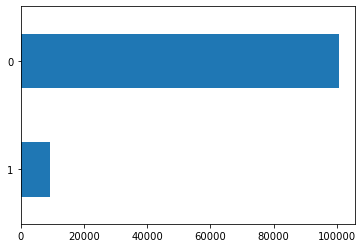

In [16]:
data['default'].value_counts(ascending=True).plot(kind='barh')

In [17]:
data.drop(['client_id','app_date',], axis = 1, inplace=True)
data = pd.get_dummies(data, columns=['education'], dummy_na=True)

In [18]:
#бинарные переменные, категориальные переменные, числовые переменные
bin_cols, cat_cols, num_cols = value_type(data, isprint=False)
bin_cols.remove('default')
bin_cols.remove('sample')
print(cat_cols)

['region_rating', 'home_address', 'work_address', 'sna', 'first_time']


In [19]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

# убедимся в преобразовании    
data.sample(5)

,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,...,first_time,foreign_passport,sample,default,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,education_nan
97858,1,34,0,0,0,0,-2.526,4,70,2,...,4,0,1,0,0,1,0,0,0,0
56698,1,29,1,0,1,0,-1.769,1,40,2,...,3,0,1,0,0,0,0,1,0,0
38693,1,33,1,1,0,1,-2.725,2,80,2,...,3,1,1,0,0,1,0,0,0,0
98563,0,45,0,0,0,0,-1.714,0,50,2,...,1,0,1,0,0,0,0,1,0,0
47530,0,25,0,0,0,0,-2.187,5,50,2,...,4,0,1,0,0,0,0,1,0,0


In [20]:
data

,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,...,first_time,foreign_passport,sample,default,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,education_nan
0,1,29,1,1,0,0,-2.272,3,50,1,...,4,0,0,0,0,1,0,0,0,0
1,0,39,0,0,5,0,-1.505,2,50,1,...,3,0,0,0,0,0,0,1,0,0
2,1,50,1,1,0,0,-1.691,1,50,1,...,3,1,0,0,0,0,0,0,1,0
3,1,56,0,0,0,0,-2.374,1,40,1,...,3,0,0,0,0,0,0,1,0,0
4,0,38,0,0,0,0,-2.488,0,80,2,...,3,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,0,45,0,0,0,0,-1.792,3,50,1,...,4,0,1,0,0,1,0,0,0,0
110144,1,41,1,1,0,0,-2.058,1,50,2,...,4,0,1,0,0,0,0,1,0,0
110145,1,31,0,0,0,0,-1.513,4,80,2,...,2,0,1,0,0,0,0,1,0,0
110146,0,29,0,0,0,1,-1.479,3,50,1,...,3,0,1,1,0,0,0,1,0,0


# Визуализация данных

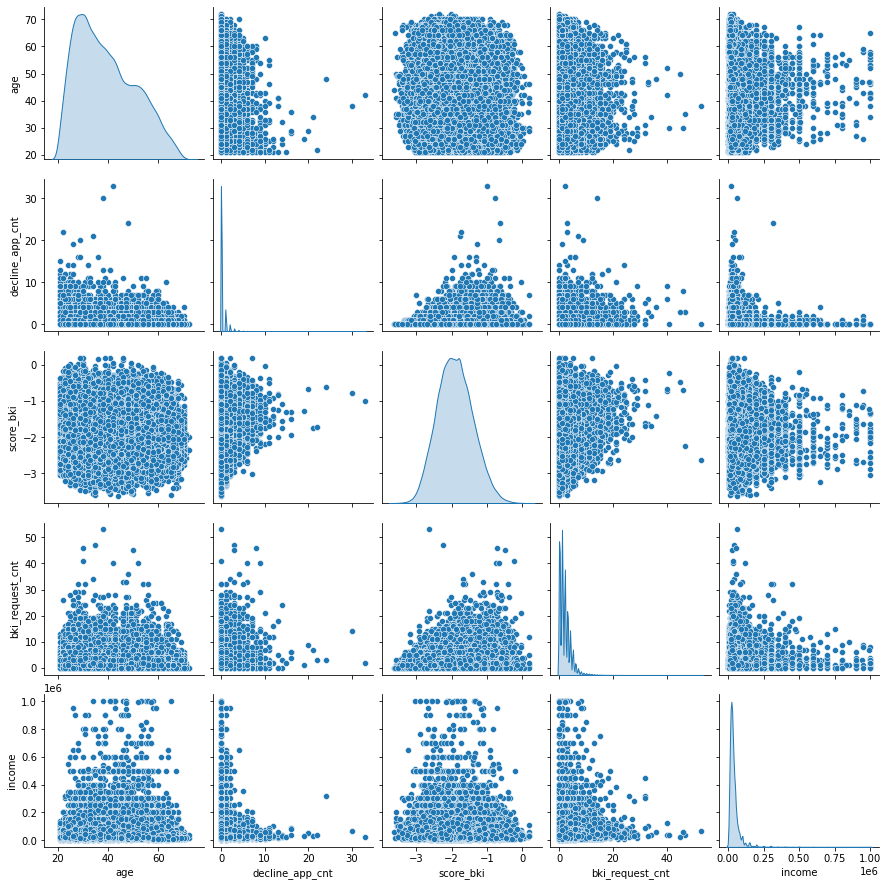

In [21]:
sns.pairplot(data[num_cols], diag_kind ='kde')

C:\Users\Max\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


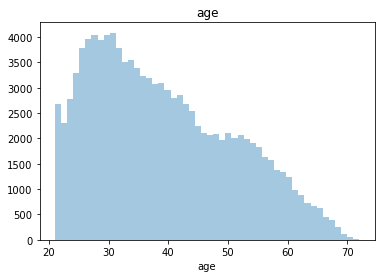

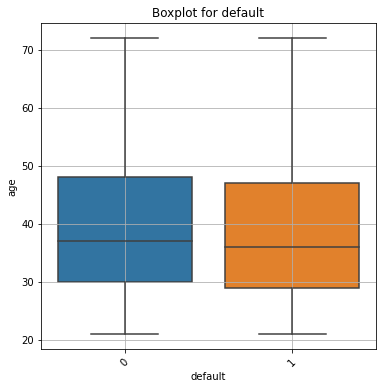

C:\Users\Max\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


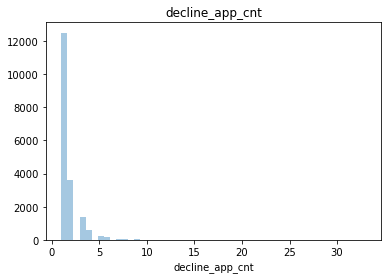

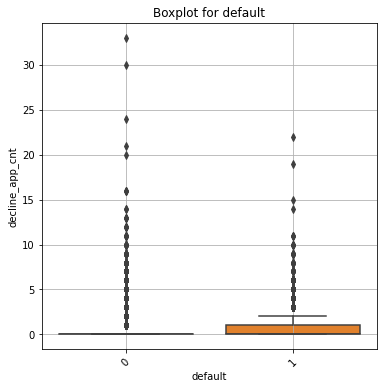

C:\Users\Max\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


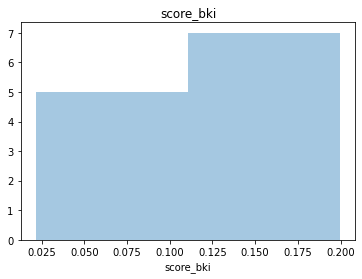

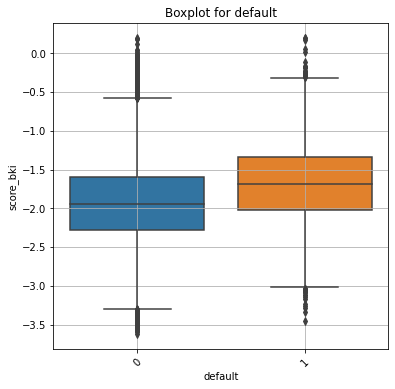

C:\Users\Max\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


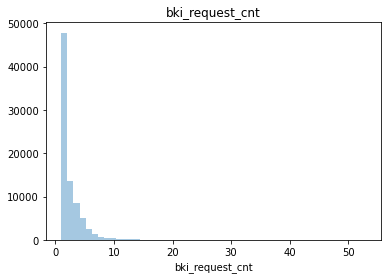

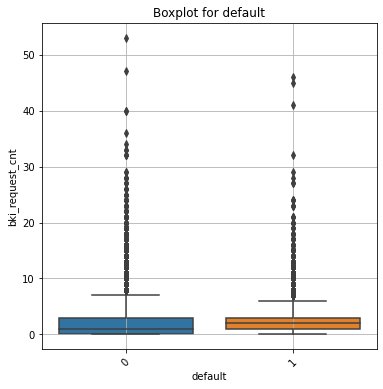

C:\Users\Max\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


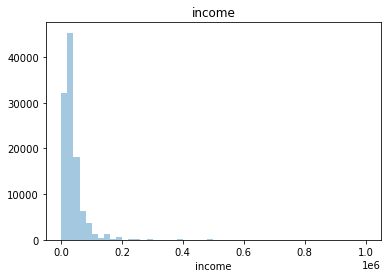

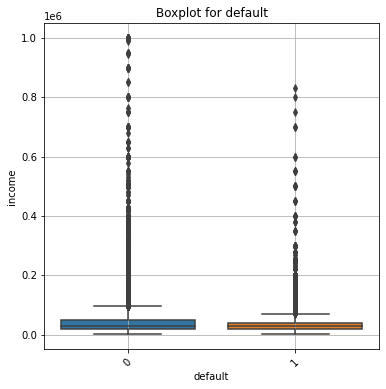

In [22]:
for col in num_cols:
    plt.figure()
    sns.distplot(data[col][data[col] > 0].dropna(), kde = False, rug=False)
    plt.title(col)
    plt.show()
    get_boxplot(data, 'default', col)

Распределение далеко от нормального. Логарифмируем числовые признаки. (кроме bki_score, признак знакопеременный)

In [23]:
for col in num_cols:
    if col != "score_bki":
        data[col] = np.log(data[col] + 1)

C:\Users\Max\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


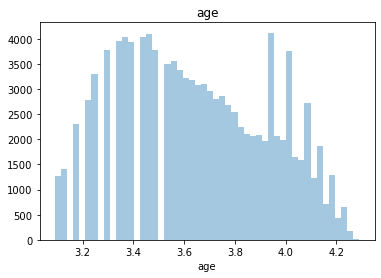

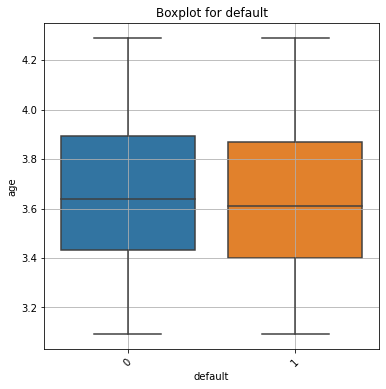

C:\Users\Max\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


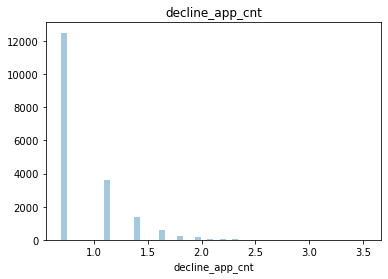

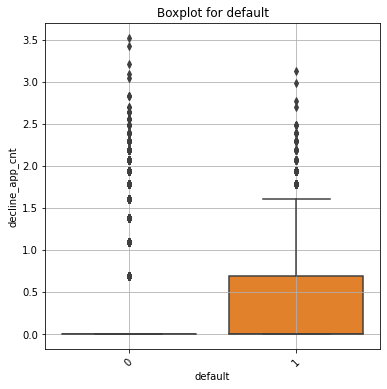

C:\Users\Max\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


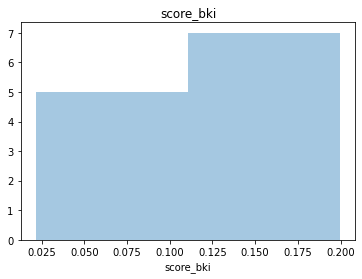

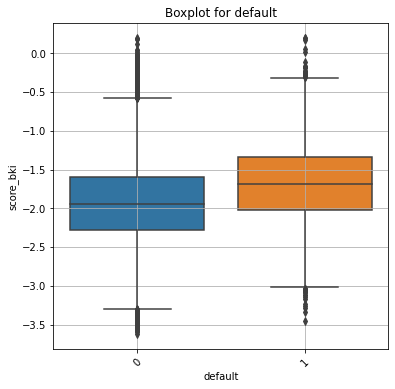

C:\Users\Max\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


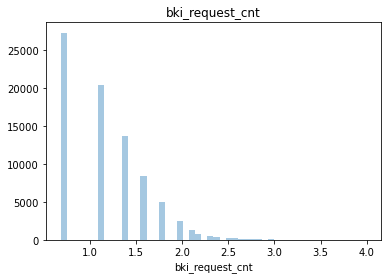

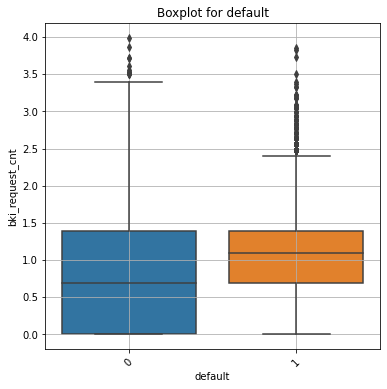

C:\Users\Max\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


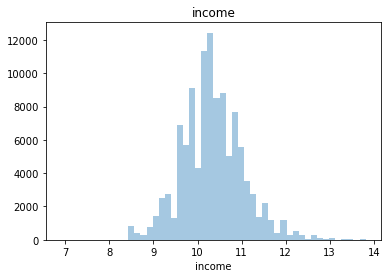

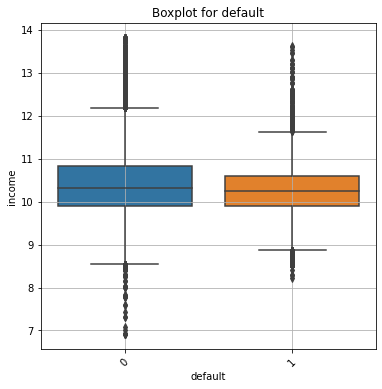

In [24]:
for col in num_cols:
    plt.figure()
    sns.distplot(data[col][data[col] > 0].dropna(), kde = False, rug=False)
    plt.title(col)
    plt.show()
    get_boxplot(data, 'default', col)

Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn.   

In [25]:
print(num_cols)
f_classif(data[num_cols], data['default'])

['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']


(array([  44.27470383, 1125.30475698, 2194.86554647,  429.87098518,
         204.97505922]),
 array([2.86709448e-011, 1.82431378e-245, 0.00000000e+000, 2.63931697e-095,
        1.88796489e-046]))

Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.

<AxesSubplot:>

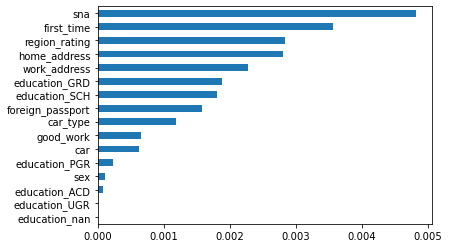

In [26]:
imp_cat = pd.Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [27]:
data = pd.get_dummies(data, columns = cat_cols)

In [28]:
#df_comb = data.copy()
#cc = list(combinations(df_comb[num_cols],2))

#df_comb = pd.concat([ df_comb[c[1]] * (df_comb[c[0]]) for c in cc], axis=1, keys=cc)
#df_comb.columns = df_comb.columns.map('_'.join)
#df_comb = pd.concat([data, df_comb], axis=1)
#data = df_comb

In [29]:
data

,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,foreign_passport,...,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4
0,1,3.401,1,1,0.000,0,-2.272,1.386,10.820,0,...,1,0,1,0,0,0,0,0,0,1
1,0,3.689,0,0,1.792,0,-1.505,1.099,8.517,0,...,1,0,0,0,0,1,0,0,1,0
2,1,3.932,1,1,0.000,0,-1.691,0.693,10.309,1,...,1,0,1,0,0,0,0,0,1,0
3,1,4.043,0,0,0.000,0,-2.374,0.693,9.741,0,...,1,0,1,0,0,0,0,0,1,0
4,0,3.664,0,0,0.000,0,-2.488,0.000,11.695,0,...,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,0,3.829,0,0,0.000,0,-1.792,1.386,9.741,0,...,1,0,0,0,0,1,0,0,0,1
110144,1,3.738,1,1,0.000,0,-2.058,0.693,11.156,0,...,1,0,1,0,0,0,0,0,0,1
110145,1,3.466,0,0,0.000,0,-1.513,1.609,10.714,0,...,0,1,0,1,0,0,0,1,0,0
110146,0,3.401,0,0,0.000,1,-1.479,1.386,9.473,0,...,0,1,0,1,0,0,0,0,1,0


# Разбиение и нормализация данных

In [30]:
# Теперь выделим тестовую часть и избавимся от дисбаланса в данных
test_data = data.query('sample == 0').drop(['sample', 'default'], axis=1)
tr_data = data.query('sample == 1').drop(['sample'], axis=1)
tr_data

,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,foreign_passport,...,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4
36349,1,4.143,1,1,0.000,0,-2.009,0.693,9.798,0,...,1,0,0,0,0,1,1,0,0,0
36350,0,4.094,0,0,0.000,0,-1.532,1.386,9.852,0,...,0,1,0,0,0,1,1,0,0,0
36351,1,3.258,1,0,1.099,0,-1.408,0.693,10.309,1,...,1,0,1,0,0,0,0,0,0,1
36352,0,3.989,0,0,0.000,0,-2.057,1.099,9.210,0,...,0,1,1,0,0,0,0,0,1,0
36353,1,3.892,0,0,0.000,1,-1.245,0.693,10.309,1,...,0,1,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,0,3.829,0,0,0.000,0,-1.792,1.386,9.741,0,...,1,0,0,0,0,1,0,0,0,1
110144,1,3.738,1,1,0.000,0,-2.058,0.693,11.156,0,...,1,0,1,0,0,0,0,0,0,1
110145,1,3.466,0,0,0.000,0,-1.513,1.609,10.714,0,...,0,1,0,1,0,0,0,1,0,0
110146,0,3.401,0,0,0.000,1,-1.479,1.386,9.473,0,...,0,1,0,1,0,0,0,0,1,0


In [31]:
train_data = pd.concat([tr_data[tr_data.default == 0].iloc[:tr_data["default"].value_counts()[1]], \
                         tr_data[tr_data.default == 1]],axis=0, ignore_index=True)

In [32]:
X = tr_data.drop(['default'], axis=1)
y = tr_data['default'].values  # наш таргет

In [441]:
RANDOM_SEED = 42
# Воспользуемся специальной функцией train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_t, X_valid, y_t, y_valid = train_test_split(tr_data.drop(['default'], axis=1), tr_data['default'].values , test_size=0.2, random_state=RANDOM_SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X, y,stratify=y, test_size=0.2, random_state=RANDOM_SEED)

# Стандартизуем числовые переменные при помощи RobustScaler
scaler =  RobustScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols].values)
X_valid[num_cols] = scaler.transform(X_valid[num_cols].values)
X[num_cols] = scaler.transform(X[num_cols].values)

In [442]:
# проверяем
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((59039, 37), (14760, 37), (59039,), (14760,))

# Обучение модели

In [443]:
LogReg = LogisticRegression(solver='liblinear', max_iter=1000)
LogReg.fit(X_train, y_train)
y_pred = LogReg.predict(X_valid)

prec = 0.46 acc = 0.87 F1-score = 0.06
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     12886
           1       0.46      0.03      0.06      1874

    accuracy                           0.87     14760
   macro avg       0.67      0.51      0.49     14760
weighted avg       0.82      0.87      0.82     14760



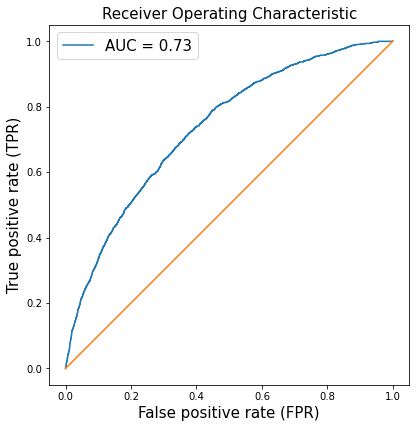

In [444]:
print_logisitc_metrics(y_valid, y_pred)
y_pred_proba = LogReg.predict_proba(X_valid)[:,1]
calc_and_plot_roc(y_valid, y_pred_proba)
report = classification_report(y_valid, y_pred, zero_division=0)
print(report)

Text(0.5, 320.8, 'Predicted label')

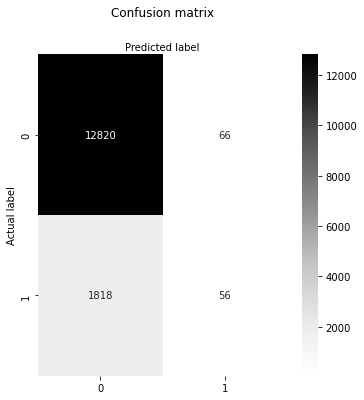

In [445]:
cnf_matrix = confusion_matrix(y_valid, y_pred)

class_names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Greys" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [446]:
# запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой останова tol1e-3
# чтобы получить оптимальные параметры модели в первом приближении
model = LogisticRegression()

iter_ = 500
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear'],#, 'lbfgs'], 
     'class_weight':[None, 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':[None, 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]   
     },
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':[None, 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]}
]

## model логистической регрессии
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_

##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 500
	multi_class: 'ovr'
	n_jobs: None
	penalty: 'none'
	random_state: None
	solver: 'sag'
	tol: 0.001
	verbose: 0
	warm_start: False


In [447]:
LogReg = gridsearch.best_estimator_
result = LogReg.fit(X_train, y_train)

prec = 0.23 acc = 0.66 F1-score = 0.34


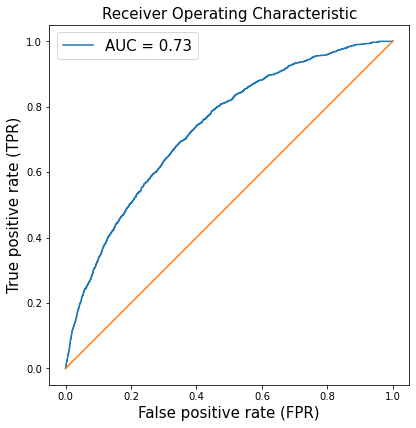

In [451]:
LogReg = LogisticRegression(class_weight='balanced' ,max_iter= 500,multi_class= 'ovr',	penalty= 'none',random_state= 42,	solver= 'sag',	tol= 0.001)
result = LogReg.fit(X_train, y_train)

y_pred = LogReg.predict(X_valid)
print_logisitc_metrics(y_valid, y_pred)
y_pred_proba = LogReg.predict_proba(X_valid)[:,1]
calc_and_plot_roc(y_valid, y_pred_proba)

Y_pred = LogReg.predict(X_valid)
cnf_matrix = confusion_matrix(y_valid, y_pred)

              precision    recall  f1-score   support

           0       0.93      0.66      0.78     12886
           1       0.23      0.68      0.34      1874

    accuracy                           0.66     14760
   macro avg       0.58      0.67      0.56     14760
weighted avg       0.84      0.66      0.72     14760



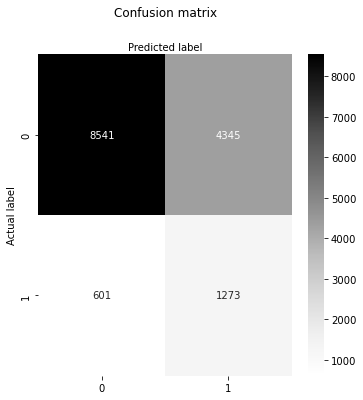

In [452]:
Report = classification_report(y_valid, Y_pred)
print(Report)
plot_confusion_matrix(cnf_matrix)

# Экспериментальные модели

In [453]:
Tree = DecisionTreeClassifier(max_features="sqrt",random_state=RANDOM_SEED)
TreeBag = BaggingClassifier(
    Tree,
    n_estimators=500,
    random_state=RANDOM_SEED,
    n_jobs=-1
)
cross_val_score(TreeBag, X, y, cv=5, scoring='f1').mean()

0.04978247225925017

In [43]:
cross_val_score(TreeBag, X_train, y_train, cv=5, scoring='f1')

array([0.03419886, 0.03055379, 0.04887218, 0.0440806 , 0.04613466])

In [44]:
y_valid.mean()

0.12696476964769648

In [56]:
RF = RandomForestClassifier(class_weight='balanced_subsample',random_state=RANDOM_SEED, oob_score=True, bootstrap=True,
     max_depth=10, min_samples_leaf=5,min_samples_split=5, max_features='sqrt', n_estimators=200, n_jobs = -1)
RF.fit(X_train,y_train)
y_pred_rand = RF.predict(X_valid)
F1 = f1_score(y_valid,y_pred_rand)
F1

0.3500840079425691

'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}

In [73]:
[int(x) for x in np.linspace(start = 100, stop = 500, num = 17)]

[100,
 125,
 150,
 175,
 200,
 225,
 250,
 275,
 300,
 325,
 350,
 375,
 400,
 425,
 450,
 475,
 500]

In [75]:
[int(x) for x in np.linspace(2, 10, num = 8)]

[2, 3, 4, 5, 6, 7, 8, 10]

In [76]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 17)]
#max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(2, 10, num = 8)]
#max_depth.append(None)
min_samples_split = [2, 3,4,5, 10]
min_samples_leaf = [1, 2, 4, 10]
#bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
 #              'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [77]:
rf = RandomForestClassifier(random_state=RANDOM_SEED, class_weight='balanced_subsample')
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=10, 
                               cv=3, verbose=2, random_state=RANDOM_SEED, n_jobs=-1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                    random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [2, 3, 4, 5, 6, 7, 8, 10],
                                        'min_samples_leaf': [1, 2, 4, 10],
                                        'min_samples_split': [2, 3, 4, 5, 10],
                                        'n_estimators': [100, 125, 150, 175,
                                                         200, 225, 250, 275,
                                                         300, 325, 350, 375,
                                                         400, 425, 450, 475,
                                                         500]},
                   random_state=42, verbose=2)

In [78]:
print(rf_random.best_params_)
y_pred_rand = rf_random.predict(X_valid)
F1 = f1_score(y_valid,y_pred_rand)
F1

{'n_estimators': 350, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 8}


0.342727658971817

In [348]:
class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = y_train)
sample_weights = np.zeros(len(y_train))
sample_weights[y_train == 0] = class_weights[0]
sample_weights[y_train == 1] = class_weights[1]

In [381]:
GBC = GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000, max_depth=2, warm_start=True,
         min_samples_leaf=1, min_samples_split=4, verbose=1, max_features='sqrt',  random_state=RANDOM_SEED)

GBC.fit(X_train, y_train, sample_weight=sample_weights)
y_pred = GBC.predict(X_valid)
print(f1_score(y_valid, y_pred))

      Iter       Train Loss   Remaining Time 
         1           1.3722           23.91s
         2           1.3636           20.90s
         3           1.3584           19.22s
         4           1.3504           18.63s
         5           1.3411           19.85s
         6           1.3361           19.17s
         7           1.3328           18.39s
         8           1.3298           17.93s
         9           1.3259           17.79s
        10           1.3222           17.57s
        20           1.2828           18.72s
        30           1.2587           18.51s
        40           1.2446           18.07s
        50           1.2352           17.64s
        60           1.2279           17.52s
        70           1.2226           17.05s
        80           1.2185           16.95s
        90           1.2153           16.64s
       100           1.2125           16.50s
       200           1.1997           14.39s
       300           1.1948           12.65s
       40

<AxesSubplot:xlabel='name'>

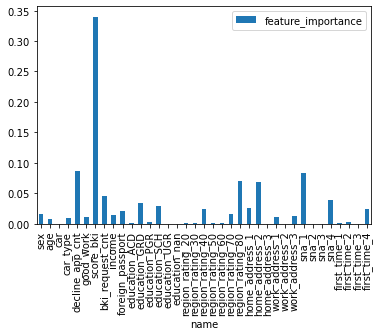

In [379]:
coefs = pd.DataFrame()
coefs['name']= np.array(X.columns)
coefs['feature_importance']= GBC.feature_importances_
coefs.plot(x="name", y="feature_importance", kind="bar")

              precision    recall  f1-score   support

           0       0.93      0.67      0.78     12886
           1       0.23      0.68      0.34      1874

    accuracy                           0.67     14760
   macro avg       0.58      0.67      0.56     14760
weighted avg       0.84      0.67      0.72     14760



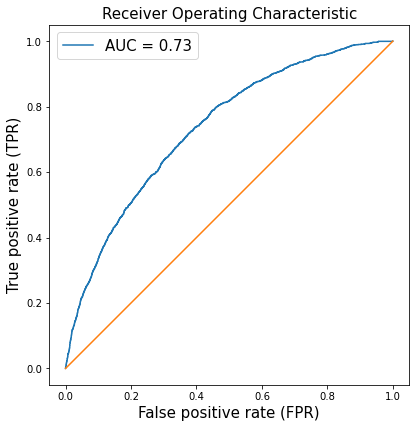

In [380]:
y_pred_proba = LogReg.predict_proba(X_valid)[:,1]
calc_and_plot_roc(y_valid, y_pred_proba)
report = classification_report(y_valid, y_pred, zero_division=0)
print(report)

# Стекинг

In [426]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

100%|██████████| 4/4 [02:16<00:00, 34.19s/it]


In [431]:
stacked_features_train, stacked_features_test = generate_meta_features([
    RandomForestClassifier(class_weight="balanced_subsample", n_estimators=300,max_depth=1, n_jobs=-1, random_state=RANDOM_SEED),
    ExtraTreesClassifier(n_estimators=300, n_jobs=-1, random_state=RANDOM_SEED),
    KNeighborsClassifier( n_jobs=-1),
    LogisticRegression(max_iter= 500,multi_class= 'ovr', penalty= 'none',random_state= 42,	solver= 'sag',	tol= 0.001)
], X_train.values, X_valid.values, y_train, cv)

100%|██████████| 4/4 [02:08<00:00, 32.19s/it]


In [430]:
print(compute_metric(RandomForestClassifier(class_weight="balanced_subsample",n_estimators=100, n_jobs=-1, random_state=RANDOM_SEED),
         stacked_features_train, y_train, stacked_features_test, y_valid))
print(compute_metric(LogisticRegression(class_weight="balanced", solver='lbfgs',max_iter=500, random_state=RANDOM_SEED),
         stacked_features_train, y_train, stacked_features_test, y_valid))
print(compute_metric(KNeighborsClassifier(),
         stacked_features_train, y_train, stacked_features_test, y_valid))

0.505566
0.579037
0.534916


# Вывод на тест

In [ ]:
# если качество нас устраивает, обучаем финальную модель на всех обучающи данных
logreg_final = LogisticRegression(solver='liblinear', max_iter=1000)
logreg_final.fit(X, y)

In [ ]:
predict_submission = logreg_final.predict(test_data)

In [ ]:
sample_submission['default'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

In [ ]:
sample_submission.describe()

In [ ]:
!kaggle competitions submit -c sf-scoring -f ssubmission.csv -m "Message"
# !kaggle competitions submit your-competition-name -f submission.csv -m 'My submission message'